In [19]:
%load_ext autoreload 
%autoreload 2 

import torch
from torch.utils.data import DataLoader
from train import Trainer
from generator import *
from discriminator import GAN
from dataset import CocoStuffDataSet
import os, argparse, datetime, json

from utils import *
NUM_CLASSES = 11
SAVE_DIR = "../checkpoints" # Assuming this is launched from code/ subfolder.
# experiment_name = 'gan_animal'
# experiment_name = 'animal-batchnorm-50-nobnend'
experiment_name = 'animal-bn-50-gan-55'
use_bn = True
experiment_dir = os.path.join(SAVE_DIR, experiment_name)
batch_size = 64
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
HEIGHT, WIDTH = 128, 128
val_loader = DataLoader(CocoStuffDataSet(mode='val', supercategories=['animal'], height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=False)
train_loader = DataLoader(CocoStuffDataSet(mode='train', supercategories=['animal'], height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=False)

In [20]:
generator = SegNet16(NUM_CLASSES, use_bn=use_bn)


image_shape = (3, HEIGHT, WIDTH)
segmentation_shape = (NUM_CLASSES, HEIGHT, WIDTH)
# discriminator = GAN(NUM_CLASSES, segmentation_shape, image_shape)
discriminator = None
trainer = Trainer(generator, discriminator, train_loader, val_loader, \
                experiment_dir=experiment_dir, resume=True, load_iter=None)


Using BatchNorm in decoder
44
Using device cuda:0
Runing network without GAN loss.
=> loading checkpoint '../checkpoints/animal-bn-50-gan-55/best.pth.tar'
=> loaded checkpoint '../checkpoints/animal-bn-50-gan-55/best.pth.tar' (iter 151)


In [ ]:
def visualize_mask(trainer, loader, number):
    total = 0
    to_return = []
    for data, mask_gt, gt_visual in loader:
        if total < number:      
            data = data.to(trainer.device)
            batch_size = data.size()[0]
            total += batch_size
            mask_pred = convert_to_mask(trainer._gen(data))
            for i in range(len(data)):
                img = de_normalize(data[i].detach().cpu().numpy())
                gt_mask = gt_visual[i].detach().cpu().numpy()
                pred_mask = np.argmax(mask_pred[i].detach().cpu().numpy(), axis=0)
                to_return.append((img, gt_mask, pred_mask))
                display_image = np.transpose(img, (1, 2, 0))
                plt.figure()

                plt.subplot(131)
                plt.imshow(display_image)
                plt.axis('off')
                plt.title('original image')

                cmap = discrete_cmap(NUM_CLASSES, 'Paired')
                norm = colors.NoNorm(vmin=0, vmax=NUM_CLASSES)

                plt.subplot(132)
                plt.imshow(display_image)
                plt.imshow(gt_mask, alpha=0.8, cmap=cmap, norm=norm)
                plt.axis('off')
                plt.title('real mask')

                plt.subplot(133)
                plt.imshow(display_image)
                plt.imshow(pred_mask, alpha=0.8, cmap=cmap, norm=norm)
                plt.axis('off')
                plt.title('predicted mask')
                plt.show()
        else:
            break
    return to_return

In [ ]:
visualize_mask(trainer, train_loader, 30)

In [ ]:
visualize_mask(trainer, val_loader, 20)

In [ ]:
val_pixel_acc, val_mIOU, per_class_accuracy = trainer.evaluate(val_loader, 0, ignore_background=True, save_mask=False)

print ("Pixel accuracy {}".format(val_pixel_acc))
print ("Val mIOU {}".format(val_mIOU))
print ("per_class_accuracy {}".format(per_class_accuracy))

In [21]:
## CONFUSION MATRIX ##

confusion_matrix = trainer.get_confusion_matrix(val_loader)


['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'background']


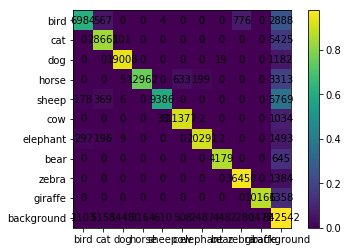

In [22]:
dataset = val_loader.dataset
coco = dataset.coco
all_cats_ids = coco.getCatIds()
cats = coco.loadCats(all_cats_ids)
nms=[cat['name'] for cat in cats]

animal_cat_names = [nms[all_cats_ids.index(i)] for i in val_loader.dataset.catIds] + ['background']
print (animal_cat_names)
visualize_conf(confusion_matrix, animal_cat_names)